In [200]:
import math
import numpy as np
from collections import namedtuple
from tqdm.notebook import tqdm
import sys
import os
import matplotlib.pyplot as plt
from itertools import product
from random import *

plt.rcParams['figure.figsize'] = [12, 6]

Customer = namedtuple("Customer", ['index', 'demand', 'x', 'y'])

def length(customer1, customer2):
    return math.sqrt((customer1.x - customer2.x)**2 + (customer1.y - customer2.y)**2)

def plot_data(customers,*args):
    for i in customers:
        if i.index!=0:
            plt.plot(i.x, i.y,'k.')
            plt.annotate(i.index,(i.x, i.y))
        else:
            plt.plot(i.x, i.y,'ro')
            plt.annotate('Dep.',(i.x, i.y))
    if args==None:
        return
    else:
        sol=args[0]
        cmap = plt.cm.rainbow
        c_idx=0
        for tour in sol:
            for i in range(len(tour)):
                plt.plot((customers[tour[i-1]].x, customers[tour[i]].x),
                 (customers[tour[i-1]].y, customers[tour[i]].y),'-',
                         color=cmap(c_idx/len(sol)))     
            c_idx+=1

            
def fits_capacity(v_tour,v_cap,customers):
    tot_demand=0
    for c in v_tour:
        tot_demand+=customers[c].demand
    if tot_demand<=v_cap:
        return True
    else:
        return False

def tour_cost(v_tour,customers):
    cost=0
    for i in range(len(v_tour)):
        cost+=length(customers[v_tour[i-1]],customers[v_tour[i]])
    return cost

def tour_demand(v_tour,customers):
    dem=0
    for i in v_tour:
        dem+=customers[i].demand
    return dem

def place_customer(in_tour, customer, customers):
    best_tour = in_tour[:]
    best_tour.insert(1,customer)
    best_cost = tour_cost(best_tour, customers)

    for i in range(1,len(best_tour)-1):
        new_tour = in_tour[:]
        new_tour.insert(i, customer)
        new_cost = tour_cost(new_tour, customers)
        if new_cost<best_cost:
            best_cost = new_cost
            best_tour = new_tour
    return best_tour

def objec(tours,customers):
    obj=0
    for t in tours:
        obj+=tour_cost(t,customers)
    return obj

def idx_two_opt(sol, idx1, idx2):
    # makes the reversal 
    if idx1<idx2:
        sol1=sol[:idx1]
        sol2=list(reversed(sol[idx1:idx2+1]))
        sol3=sol[idx2+1:]
    else:
        sol1=sol[:idx2]
        sol2=list(reversed(sol[idx2:idx1+1]))
        sol3=sol[idx1+1:]
    new_sol=sol1+sol2+sol3
    return new_sol

def two_opt_search(tour,customers):
    nodeCount=len(tour)
    best_tour=tour
    best_obj=tour_cost(tour,customers)
    for i in range(1,nodeCount-1):
            for j in range(1,nodeCount-1):
                p_tour=idx_two_opt(best_tour,i,j)
                p_obj=tour_cost(p_tour,customers)
                if p_obj<best_obj:
                    best_tour=p_tour
                    best_obj=p_obj
    return best_tour

def four_swap(vehicle_tours,candidates,customers,v_cap):
    local_cpy_tours = [a for a in vehicle_tours]
    # calculate initial objective
    start_obj = objec(vehicle_tours,customers)
    c_tours = []
    for c in candidates:
        for i in range(len(vehicle_tours)):
            if c in vehicle_tours[i]:
                c_tours.append((c,i))
                break
    # instantiates the set of all currently used tours amongst sourced clients 
    used_tours = set()
    for c in c_tours:
        used_tours.add(c[1])
    # remove candidates from tours trying to realocate
    for c in c_tours:
        #local_cpy_tours[c[1]].remove(c[0])
        local_cpy_tours[c[1]] = [i for i in vehicle_tours[c[1]] if i!=c[0]]
    # try to permute candidates between tours keeping the best objective
    best_obj = start_obj
    best_tours = [a for a in vehicle_tours]
    #print('initial best tours',best_tours)
    for perms in product(used_tours,repeat=4):
        # checks if current perm fits capacity
        # still need to check if perms[i]==perms[j]
        cand_tours = local_cpy_tours[:]
        for i in range(4):
            cand_tours[perms[i]] = place_customer(cand_tours[perms[i]],
                                                  candidates[i], customers)
        # checks if cand_tours fits capacity
        fits = True
        for t in cand_tours:
            if not fits_capacity(t,v_cap,customers):
                fits = False
        if fits == True:
            # calculate candidate objective
            cand_obj = objec(cand_tours,customers)
            if cand_obj < best_obj:
                best_obj = cand_obj
                best_tours = cand_tours.copy()
    return best_tours

In [207]:
def vr_solver(input_data):
    # Currently returns infeasible solutions for some problems!

    # parse the input
    lines = input_data.split('\n')

    parts = lines[0].split()
    customer_count = int(parts[0])
    vehicle_count = int(parts[1])
    vehicle_capacity = int(parts[2])
    
    print('Customer Count:',customer_count)
    print('Vehicle Count',vehicle_count)
    print('Vehicle Cap.',vehicle_capacity)
    
    customers = []
    for i in range(1, customer_count+1):
        line = lines[i]
        parts = line.split()
        customers.append(Customer(i-1, int(parts[0]), float(parts[1]), float(parts[2])))

    #the depot is always the first customer in the input
    depot = customers[0] 
    
    for c in customers:
        print('c={}, dem={}'.format(c.index,c.demand))
    # greedy solution
    # assign customers to vehicles sorted by a balance (alpha) of distance and demand

    
    obj_hist = []
    
    best_obj = float('Inf')
    best_tours = []
    
    alpha_n=50
    # Iterate in a range alpha taking the best!
    for alpha in tqdm(np.linspace(0,1,alpha_n)):
        vehicle_tours = []
        remaining_customers = set(customers)
        remaining_customers.remove(depot)
        for v in range(0, vehicle_count):
            # print "Start Vehicle: ",v
            vehicle_tours.append([])
            capacity_remaining = vehicle_capacity
            current_c=0
            full=False
            while len(remaining_customers)>0 and not full:
                sorted_rem_cust=sorted(remaining_customers,
                                        key=lambda x: alpha*(length(customers[current_c],x)) + 
                                       (1-alpha)*(-x.demand), reverse = False)
                for c in sorted_rem_cust:
                    if c.demand<=capacity_remaining:
                        capacity_remaining=capacity_remaining-c.demand
                        remaining_customers.remove(c)
                        current_c=c.index
                        vehicle_tours[v].append(c.index)
                        break
                #check if vehicle is effectively full!!
                full=True
                for c in remaining_customers:
                    if c.demand<=capacity_remaining:
                        full=False
                        break
        # checks that the number of customers served is correct
        valid = False
        if sum([len(v) for v in vehicle_tours]) == len(customers) - 1:
            valid=True
        # calculates objective for valid tour
        if valid == True:
            # the formulation pressuposes '0' at the start and end of tour
            # adding '0' to start and end
            for t in vehicle_tours:
                t.insert(0,0)
                t.append(0)
            for i in range(len(vehicle_tours)):
                vehicle_tours[i] = two_opt_search(vehicle_tours[i],customers)
            obj=objec(vehicle_tours,customers)
            if obj<best_obj:
                best_obj=obj
                best_tours = vehicle_tours
                obj_hist.append(obj)
            else:
                obj_hist.append(obj)
        else:
            obj_hist.append(None)
    vehicle_tours = best_tours
    
    visited=[]
    for t in vehicle_tours:
        for c in t:
            visited.append(c)
    notvisited = []
    notvisited = [c for c in range(customer_count) if c not in visited]
    if len(notvisited)>0:
        print('----- NOT ALL CLIENTS VISITED!!! ----- {} remain'.format(len(notvisited)))
    
    FITS = True
    dontfit = []
    for i in range(len(vehicle_tours)):
        if not fits_capacity(vehicle_tours[i],vehicle_capacity,customers):
            FITS = False
            dontfit.append(i)
    print('All Fit?', FITS,'dontfit:',dontfit)
    
    print('Starting cost = {}'.format(objec(best_tours,customers)))
    
    # try swapping clients between tours!!!
    maxit=20
    swap_obj_hist = [objec(best_tours,customers)]
    for i in tqdm(range(maxit)):
        c_list = sample(range(1,customer_count),4)
        #print('cand_list:',c_list)
        vehicle_tours = four_swap(vehicle_tours,c_list,customers,vehicle_capacity)
        swap_obj_hist.append(objec(vehicle_tours,customers))
        if swap_obj_hist[-1]<swap_obj_hist[-2]:
            print('New best solution found on it {}. Obj: {}'.format(i+1,swap_obj_hist[-1]))
    
    visited=[]
    for t in vehicle_tours:
        for c in t:
            visited.append(c)
    notvisited = []
    notvisited = [c for c in range(customer_count) if c not in visited]
    if len(notvisited)>0:
        print('----- NOT ALL CLIENTS VISITED!!! ----- {} remain'.format(len(notvisited)))
            
    FITS = True
    dontfit = []
    for i in range(len(vehicle_tours)):
        if not fits_capacity(vehicle_tours[i],vehicle_capacity,customers):
            FITS = False
            dontfit.append(i)
    print('All Fit?', FITS,'dontfit:',dontfit)
    
    for i in range(len(vehicle_tours)):
        tour_cap=vehicle_capacity
        for c in vehicle_tours[i]:
            tour_cap = tour_cap-customers[c].demand
        print('tour={} , rem cap={}'.format(i,tour_cap))
        
    
    #plot cost curve
    plt.subplot(1,2,1)
    #plt.plot(np.linspace(0,1,alpha_n),obj_hist,'.-')
    plt.plot(swap_obj_hist)
    
    #prints the customers locations
    plt.subplot(1,2,2)
    plot_data(customers,vehicle_tours)
    
    # calculate the cost of the solution; for each vehicle the length of the route
    obj=objec(vehicle_tours,customers)
    print('Cost:',obj)

    # prepare the solution in the specified output format
    outputData = '%.2f' % obj + ' ' + str(0) + '\n'
    for v in range(0, vehicle_count):
        outputData += ' '.join([str(customers[c].index) for c in vehicle_tours[v]]) + '\n'

    return outputData


Customer Count: 16
Vehicle Count 3
Vehicle Cap. 90
c=0, dem=0
c=1, dem=7
c=2, dem=30
c=3, dem=16
c=4, dem=9
c=5, dem=21
c=6, dem=15
c=7, dem=19
c=8, dem=23
c=9, dem=11
c=10, dem=5
c=11, dem=19
c=12, dem=29
c=13, dem=23
c=14, dem=21
c=15, dem=10



All Fit? True dontfit: []
Starting cost = 284.23094386031295



All Fit? True dontfit: []
tour=0 , rem cap=5
tour=1 , rem cap=2
tour=2 , rem cap=5
Cost: 284.23094386031295
284.23 0
0 12 5 10 9 11 0
0 2 3 8 7 0
0 15 4 13 14 6 1 0



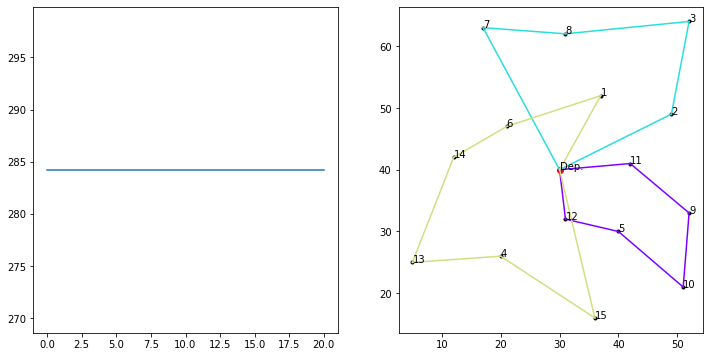

In [208]:
notebook_path = os.path.abspath("Notebook.ipynb")
data_path = os.path.join(os.path.dirname(notebook_path), "data\\vrp_16_3_1")

if len(data_path) > 1:
    file_location = data_path.strip()
    with open(file_location, 'r') as input_data_file:
        input_data = input_data_file.read()
        print(vr_solver(input_data))